In [20]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
from tensorflow.keras import layers,Model

In [21]:
# import data
trainData = pd.read_csv('train.csv',header = 0)
testData = pd.read_csv('test.csv',header = 0)

In [22]:
# Deal with missing values
def nan_padding(data, columns):
    for column in columns:
        imputer=SimpleImputer()
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

columns = ["SibSp", "Parch","Fare"]

trainData = nan_padding(trainData, columns)
testData = nan_padding(testData, columns)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [23]:
def DummyData(data, columns):
    for c in columns:
        data = pd.concat([data,pd.get_dummies(data[c],prefix = c)],axis = 1)
        data = data.drop(c,axis = 1)
    return data

columns = ['Pclass','Embarked']
trainData = DummyData(trainData,columns)
testData = DummyData(testData,columns)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1


In [24]:
def ConvertSex(data):
    le = LabelEncoder()
    le.fit(['male','female'])
    data['Sex'] = le.transform(data['Sex'])
    return
ConvertSex(trainData)
ConvertSex(testData)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1


In [25]:
# Has Cabin
trainData['HasCabin'] = trainData['Cabin'].apply(lambda x:0 if type(x) == float else 1)
testData['HasCabin'] = testData['Cabin'].apply(lambda x:0 if type(x) == float else 1)

trainData.head()
testData.head()

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin
0,892,"Kelly, Mr. James",1,34.5,0.0,0.0,330911,7.8292,NaN,0,0,1,0,1,0,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1.0,0.0,363272,7.0000,NaN,0,0,1,0,0,1,0
2,894,"Myles, Mr. Thomas Francis",1,62.0,0.0,0.0,240276,9.6875,NaN,0,1,0,0,1,0,0
3,895,"Wirz, Mr. Albert",1,27.0,0.0,0.0,315154,8.6625,NaN,0,0,1,0,0,1,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1.0,1.0,3101298,12.2875,NaN,0,0,1,0,0,1,0


In [26]:
# Change age
def ConvertAge(age):
    if age <=12 :
        return 0        
    elif age<=18:
        return 1
    else : return 2
trainData['AgeRange'] = trainData['Age'].apply(ConvertAge)
trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,AgeRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0,1,2
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1,0,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1,1,2
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1,0,2


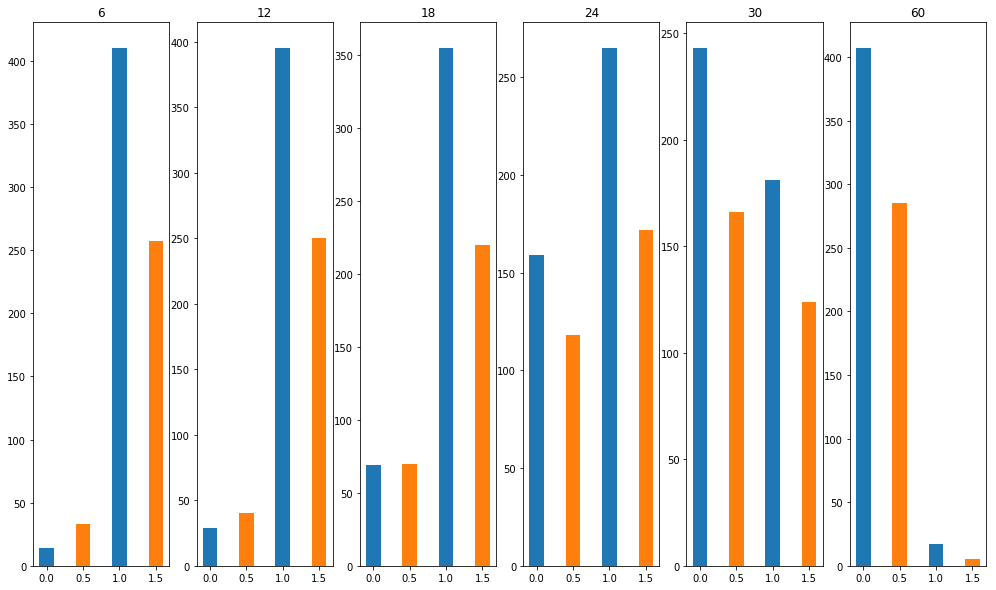

In [27]:
e = np.arange(2)
plt.figure(figsize=(20,10))
j = 1
for i in [6,12,18,24,30,60]:        
    plt.subplot(1,7,j)
    j+=1
    a = (((trainData['Age']<=i)) & (trainData['Survived'] == 0)).sum()
    b = (((trainData['Age']<=i)) & (trainData['Survived'] == 1)).sum()
    c = (((trainData['Age']> i)) & (trainData['Survived'] == 0)).sum()
    d = (((trainData['Age']> i)) & (trainData['Survived'] == 1)).sum()
    plt.title(i)
    plt.bar(e,(a,c),0.2)
    plt.bar(e+0.5,(b,d),0.2)





In [28]:
def NormalizeData(data,columns):
    scaler = MinMaxScaler()
    for c in columns:
        data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    return data


columns = ['Fare']
trainData = NormalizeData(trainData,columns)
testData = NormalizeData(testData,columns)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,AgeRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,0.014151,NaN,0,0,1,0,0,1,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,0.139136,C85,1,0,0,1,0,0,1,2
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,0.015469,NaN,0,0,1,0,0,1,0,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,0.103644,C123,1,0,0,0,0,1,1,2
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,0.015713,NaN,0,0,1,0,0,1,0,2


In [29]:
# Drop useless data
def DropColumn(data, columns):    
    return data.drop(columns,axis = 1)


columns = ['PassengerId','Name',"Ticket", "Cabin"]
trainData = DropColumn(trainData,columns)
testData = DropColumn(testData,columns)

trainData.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,AgeRange
0,0,1,22.0,1.0,0.0,0.014151,0,0,1,0,0,1,0,2
1,1,0,38.0,1.0,0.0,0.139136,1,0,0,1,0,0,1,2
2,1,0,26.0,0.0,0.0,0.015469,0,0,1,0,0,1,0,2
3,1,0,35.0,1.0,0.0,0.103644,1,0,0,0,0,1,1,2
4,0,1,35.0,0.0,0.0,0.015713,0,0,1,0,0,1,0,2


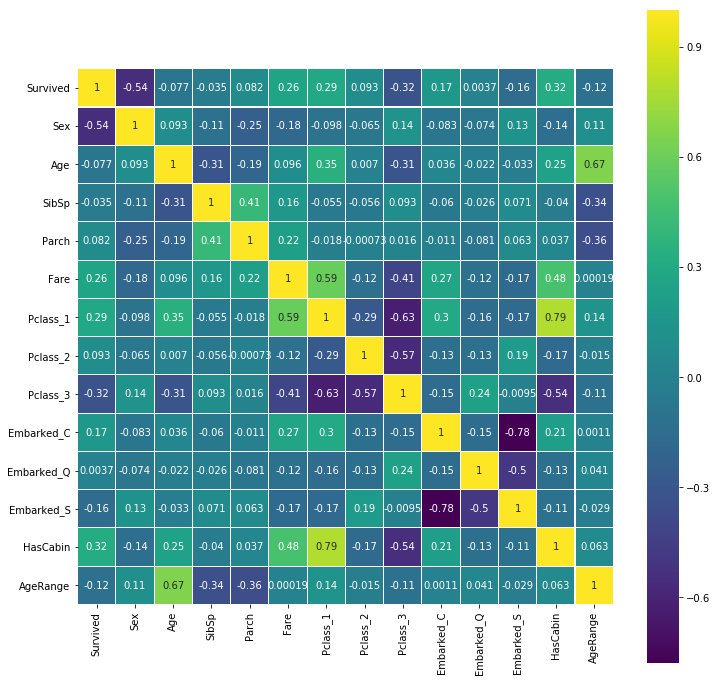

In [30]:
# Visualize co-relation
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
#plt.title("Correlation of Features")
sns.heatmap(trainData.astype(float).corr(),linewidths=0.1,vmax=1.0,square = True, cmap=colormap,linecolor='white',annot=True)

In [9]:
# train data after processing
trainData.head()


,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3
0,0,1,0.271174,1.0,0.0,0.014151,0,0,1
1,1,0,0.472229,1.0,0.0,0.139136,1,0,0
2,1,0,0.321438,0.0,0.0,0.015469,0,0,1
3,1,0,0.434531,1.0,0.0,0.103644,1,0,0
4,0,1,0.434531,0.0,0.0,0.015713,0,0,1


In [10]:
# test data after processing
testData.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,0.452723,0.0,0.0,0.015282,0,0,1
1,0,0.617566,1.0,0.0,0.013663,0,0,1
2,1,0.815377,0.0,0.0,0.018909,0,1,0
3,1,0.353818,0.0,0.0,0.016908,0,0,1
4,0,0.287881,1.0,1.0,0.023984,0,0,1


In [ ]:
trainX = trainData.iloc[:,1:].to_numpy()
trainY = trainData.loc[:,'Survived'].to_numpy()
testX = testData.iloc[:,1:].to_numpy()
testY = pd.read_csv('gender_submission.csv',header = 0).iloc[:,1].to_numpy()

In [ ]:
# Check point
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoint.ckpt" , 
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 peroid=5, 
                                                 verbose = 1)

In [ ]:
def CreateModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 1024, 
                              activation = 'relu', input_shape=(8,),                               
                              kernel_regularizer = tf.keras.regularizers.l1(0.0001)
                             ),
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.00001)),        
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.00001)),        
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.00001)),                
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model

In [ ]:
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.001),
             metrics = ['accuracy'])
model.summary()

In [ ]:
#model.load_weights('./checkpoint.ckpt')
model.fit(x = trainX,
          y = trainY,
          epochs = 2000,
          verbose = 2,
          validation_data = (testX,testY),
          callbacks=[cp_callback],
         )
          

In [ ]:
# evaluate
test_loss, test_acc = model.evaluate(testX,testY,verbose = 0)

print('test accuracy: {}, test loss: {}'.format(test_acc,test_loss))

In [ ]:
# predictions
predictions = model.predict_classes(testX).reshape(len(testX))
# write csv file
submission =pd.DataFrame({'PassengerId':testData['PassengerId'],'Survived':predictions})
submission.to_csv('Titanic Predictions.csv',index = False)